In [1]:
import os
import sys
import json
import hydra
import random

import numpy as np
import torch
import cv2
from cliport.dataset import RavensDataset
from cliport.tasks import cameras
from cliport.tasks import primitives
from cliport.tasks.grippers import Suction
from cliport.tasks.task import Task

from cliport import agents
from cliport import dataset
from cliport import tasks
from cliport.utils import utils
from cliport.environments.environment import Environment

import pybullet as p

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

oracle_cams = cameras.Oracle.CONFIG
# Workspace bounds.
pix_size = 0.003125
bounds = np.array([[0.25, 0.75], [-0.5, 0.5], [0, 0.3]])

In [2]:
class GeneralTask(Task):
    def __init__(self):
        super().__init__()
        self.max_steps = 12
        self.lang_template = "put the {pick} on a {place}"
        self.task_completed_desc = "done."

    def reset(self, env):
        super().reset(env)

    def set_goals(self, env, lines, obj_info):
    # objs, matches, targs, _, _, metric, params, max_reward = goals
    # object_id, (symmetry, _) = objs[i]
        for line in lines:
            self.goals.append(([(0, (np.pi / 2, None))],
                               np.ones((1, 1)),
                               [],
                               False, True, 'pose', None, 1))
            self.lang_goals.append(line)

    def get_colors(self):
        return utils.TRAIN_COLORS if self.mode == 'train' else utils.EVAL_COLORS
    
    def reward(self):
        self.goals.pop(0)
        if len(self.lang_goals) > 0:
            self.lang_goals.pop(0)
        return (0, {})
    
    def done(self):
        return (len(self.goals) == 0)


def get_true_image(env):
    """Get RGB-D orthographic heightmaps and segmentation masks."""
    # Capture near-orthographic RGB-D images and segmentation masks.
    color, depth, segm = env.render_camera(oracle_cams[0])

    # Combine color with masks for faster processing.
    color = np.concatenate((color, segm[Ellipsis, None]), axis=2)

    # Reconstruct real orthographic projection from point clouds.
    hmaps, cmaps = utils.reconstruct_heightmaps(
        [color], [depth], oracle_cams, bounds, pix_size)

    # Split color back into color and masks.
    cmap = np.uint8(cmaps)[0, Ellipsis, :3]
    hmap = np.float32(hmaps)[0, Ellipsis]
    mask = np.int32(cmaps)[0, Ellipsis, 3:].squeeze()
    return cmap, hmap, mask


def get_random_pose(env, obj_size):
    """Get random collision-free object pose within workspace bounds."""

    # Get erosion size of object in pixels.
    max_size = np.sqrt(obj_size[0] ** 2 + obj_size[1] ** 2)
    erode_size = int(np.round(max_size / pix_size))

    _, hmap, obj_mask = get_true_image(env)

    # Randomly sample an object pose within free-space pixels.
    free = np.ones(obj_mask.shape, dtype=np.uint8)
    for obj_ids in env.obj_ids.values():
        for obj_id in obj_ids:
            free[obj_mask == obj_id] = 0
    free[0, :], free[:, 0], free[-1, :], free[:, -1] = 0, 0, 0, 0
    free = cv2.erode(free, np.ones((erode_size, erode_size), np.uint8))
    if np.sum(free) == 0:
        return None, None
    pix = utils.sample_distribution(np.float32(free))
    pos = utils.pix_to_xyz(pix, hmap, bounds, pix_size)
    pos = (pos[0], pos[1], obj_size[2] / 2)
    theta = np.random.rand() * 2 * np.pi
    rot = utils.eulerXYZ_to_quatXYZW((0, 0, theta))
    return pos, rot

In [3]:
def setup_environment(object_list, disp=False):
    env = Environment(
        './environments/assets/',
        disp=disp,
        shared_memory=False,
        hz=480,
        # record_cfg=cfg['record']
    )
    env.seed(0)
    task = GeneralTask()
    env.set_task(task)
    obs = env.reset()
    lang_objects = object_list
    colors = []

    n_bowls = 0
    bowl_size = (0.12, 0.12, 0)
    bowl_urdf = 'bowl/bowl.urdf'

    n_blocks = 0
    block_size = (0.04, 0.04, 0.04)
    block_urdf = 'stacking/block.urdf'
    objects = {}

    for obj in lang_objects:
        print(obj)
        color_name, item = obj.split(' ')
        color = utils.COLORS[color_name]
        colors.append(color)
        if item == 'block':
            n_blocks += 1
            block_pose = get_random_pose(env, block_size)
            if block_pose == (None, None):
                block_pose = get_random_pose(env, block_size)
            print(block_pose)
            block_id = env.add_object(block_urdf, block_pose)
            p.changeVisualShape(block_id, -1, rgbaColor=color + [1])
            objects[obj] = block_id
        if item == 'bowl':
            n_bowls += 1
            bowl_pose = get_random_pose(env, bowl_size)
            bowl_id = env.add_object(bowl_urdf, bowl_pose)
            p.changeVisualShape(bowl_id, -1, rgbaColor=color + [1])
            objects[obj] = bowl_id
#         input("Enter to continue")

    return env, task, obs, objects

In [4]:
objects = ["brown block", "green block", "yellow block", "blue block", "green bowl", "red bowl", "blue bowl","yellow bowl", "pink bowl"]
lang_goals = ''
def get_object_names():
    global objects
    return objects
def put_first_on_second(obj1, obj2):
    global lang_goals
    print(obj1, obj2)
    lang_goals += 'place(\'{}\',\'{}\')\n'.format(obj1, obj2)

In [5]:
lang_goals = ["place the blue block in a green bowl", 
"place the green block in a green bowl",
"place the yellow block in a green bowl",
"place the brown block in a green bowl"]

In [8]:
vcfg = {
    'mode': 'test',
    'eval_task': 'put-block-in-bowl-seen-colors',
    'type': 'single',
    'data_dir': '/home/lily/cliport/data',
    'n_demos': 1,
    'agent': 'cliport',
    'model_path':'/home/lily/cliport/exp/multi-language-conditioned-cliport-n1000-train/checkpoints/',
    'save_path':'/home/lily/cliport/exp/put-block-in-bowl-seen-colors-cliport-n1000-train/checkpoints/',
    'update_results': True,
    'n_repeats': 1,
    'save_results': False,
    'train_config': '/home/lily/cliport/exp/multi-language-conditioned-cliport-n1000-train/.hydra/config.yaml'
    
       }

In [9]:
# @hydra.main(config_path='./cfg', config_name='eval')
def main(vcfg):
    # Load train cfg
    tcfg = utils.load_hydra_config(vcfg['train_config'])

    # Initialize environment and task.
    env, task, obs, obj_info = setup_environment(object_list=objects, disp=True)

    # Choose eval mode and task.
    mode = vcfg['mode']
    eval_task = vcfg['eval_task']
    if mode not in {'train', 'val', 'test'}:
        raise Exception("Invalid mode. Valid options: train, val, test")

    # Load eval dataset.
    dataset_type = vcfg['type']
    if 'multi' in dataset_type:
        ds = dataset.RavensMultiTaskDataset(vcfg['data_dir'],
                                            tcfg,
                                            group=eval_task,
                                            mode=mode,
                                            n_demos=vcfg['n_demos'],
                                            augment=False)
    else:
        ds = dataset.RavensDataset(os.path.join(vcfg['data_dir'], f"{eval_task}-{mode}"),
                                   tcfg,
                                   n_demos=vcfg['n_demos'],
                                   augment=False)

    all_results = {}
    name = '{}-{}-n{}'.format(eval_task, vcfg['agent'], vcfg['n_demos'])

    # Save path for results.
    json_name = f"multi-results-{mode}.json" if 'multi' in vcfg['model_path'] else f"results-{mode}.json"
    save_path = vcfg['save_path']
    print(f"Save path for results: {save_path}")
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    save_json = os.path.join(save_path, f'{name}-{json_name}')

    # Load existing results.
    existing_results = {}
    if os.path.exists(save_json):
        with open(save_json, 'r') as f:
            existing_results = json.load(f)

    # Make a list of checkpoints to eval.
#     ckpts_to_eval = list_ckpts_to_eval(vcfg, existing_results)
#     ckpts_to_eval = ['steps=160000-val_loss=0.00013488.ckpt']
    ckpts_to_eval = ['last.ckpt']
    
    # Evaluation loop
    print(f"Evaluating: {str(ckpts_to_eval)}")
    for ckpt in ckpts_to_eval:
        model_file = os.path.join(vcfg['model_path'], ckpt)

        if not os.path.exists(model_file) or not os.path.isfile(model_file):
            print(f"Checkpoint not found: {model_file}")
            continue
        elif not vcfg['update_results'] and ckpt in existing_results:
            print(f"Skipping because of existing results for {model_file}.")
            continue

        results = []
        mean_reward = 0.0

        # Run testing for each training run.
        for train_run in range(vcfg['n_repeats']):

            # Initialize agent.
            utils.set_seed(train_run, torch=True)
            agent = agents.names[vcfg['agent']](name, tcfg, None, ds)

            # Load checkpoint
            agent.load(model_file)
            print(f"Loaded: {model_file}")

#             record = vcfg['record']['save_video']
            record = False
            n_demos = vcfg['n_demos']

            # Run testing and save total rewards with last transition info.
            for i in range(0, n_demos):
                print(f'Test: {i + 1}/{n_demos}')
#                 episode, seed = ds.load(i)
#                 goal = episode[-1]
                seed = 42
                total_reward = 0
                np.random.seed(seed)

                # set task
#                 if 'multi' in dataset_type:
#                     task_name = ds.get_curr_task()
#                     task = tasks.names[task_name]()
#                     print(f'Evaluating on {task_name}')
#                 else:
#                     task_name = vcfg['eval_task']
#                     task = tasks.names[task_name]()
                task_name = vcfg['eval_task']
                task.set_goals(env, lang_goals, obj_info)
                task.mode = mode
                env.seed(seed)
                env.set_task(task)
                env.info['lang_goal'] = lang_goals.pop(0)
                info = env.info
                reward = 0

#                 for _ in range(task.max_steps):
                while len(lang_goals) >= 1:
                    act = agent.act(obs, info, None)
                    lang_goal = info['lang_goal']
                    print(f'Lang Goal: {lang_goal}')
                    obs, reward, done, info = env.step(act)
                    total_reward += reward
                    print(f'Total Reward: {total_reward:.3f} | Done: {done}\n')
                    env.info['lang_goal'] = lang_goals.pop(0)
                    num_images = len(obs['color'])
                    fig, axs = plt.subplots(2, num_images, figsize=(15, 6))
                    for n in range(num_images):
                        axs[1, n].imshow(obs['color'][n])
                        axs[1, n].set_title(f'Raw RGB {n+1}')

                        axs[0, n].imshow(obs['depth'][n])
                        axs[0, n].set_title(f'Raw Depth {n+1}')

                    plt.show()
                    if done:
                        break

                results.append((total_reward, info))
                mean_reward = np.mean([r for r, i in results])
                print(f'Mean: {mean_reward} | Task: {task_name} | Ckpt: {ckpt}')


brown block
((0.540625, 0.37187500000000007, 0.02), (0.0, 0.0, 0.9249530289483379, 0.3800814310635226))
green block
((0.46875, -0.03749999999999998, 0.02), (0.0, 0.0, 0.18681160819755788, 0.9823957568325721))
yellow block
((0.61875, 0.203125, 0.02), (0.0, -0.0, 0.8776135626323914, -0.47936878776541303))
blue block
((0.578125, -0.25, 0.02), (0.0, -0.0, 0.2527173195598535, -0.9675401575100038))
green bowl
red bowl
blue bowl
yellow bowl
pink bowl
Save path for results: /home/lily/cliport/exp/put-block-in-bowl-seen-colors-cliport-n1000-train/checkpoints/
Evaluating: ['last.ckpt']
pybullet build time: Sep 22 2020 00:56:01
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context

/home/lily/miniconda3/envs/cliport/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


Lang Goal: place the blue block in a green bowl
Total Reward: 0.000 | Done: False



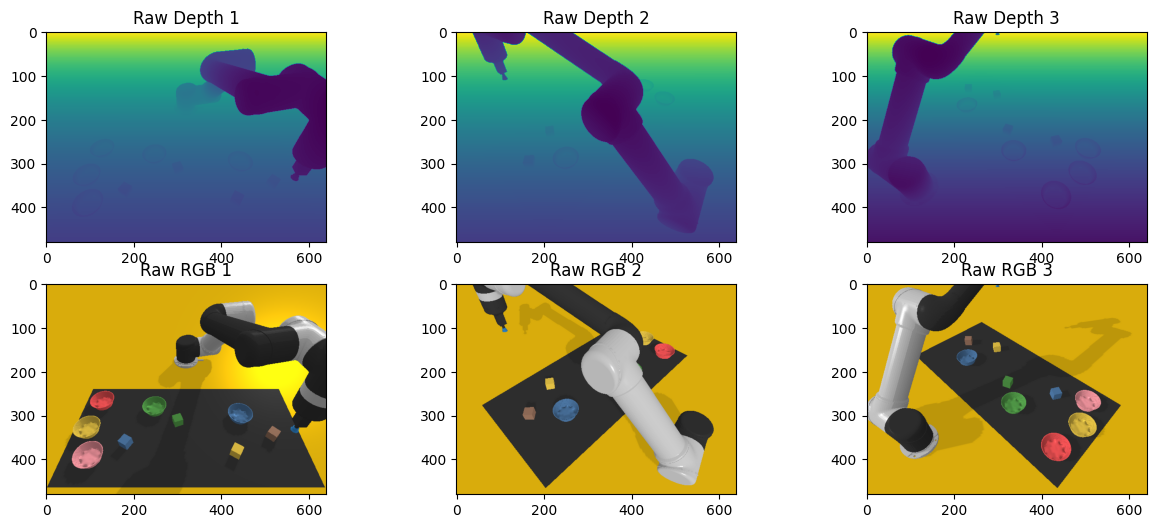

Lang Goal: place the green block in a green bowl
Total Reward: 0.000 | Done: False



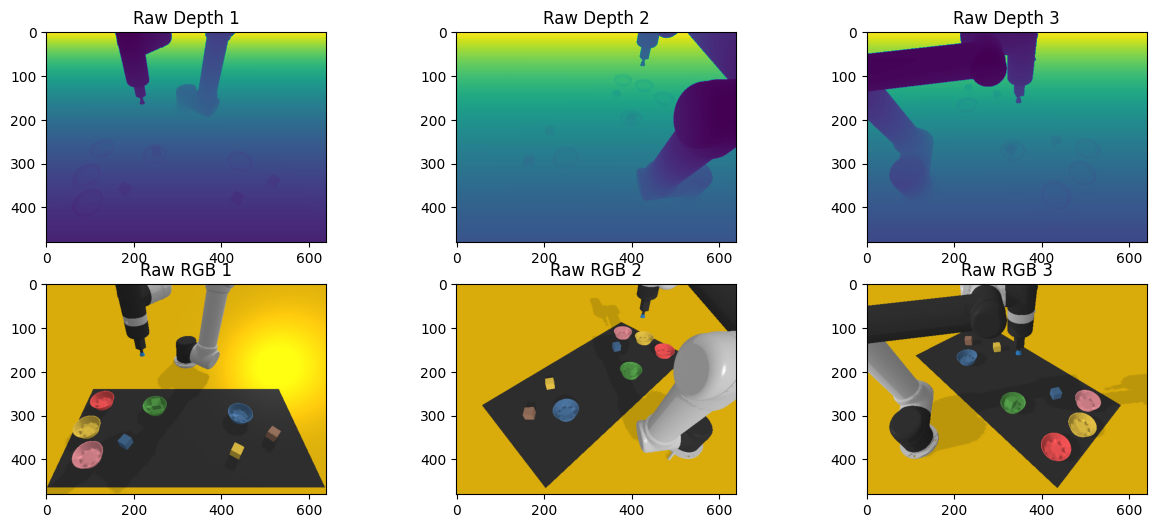

Lang Goal: place the yellow block in a green bowl
Total Reward: 0.000 | Done: False



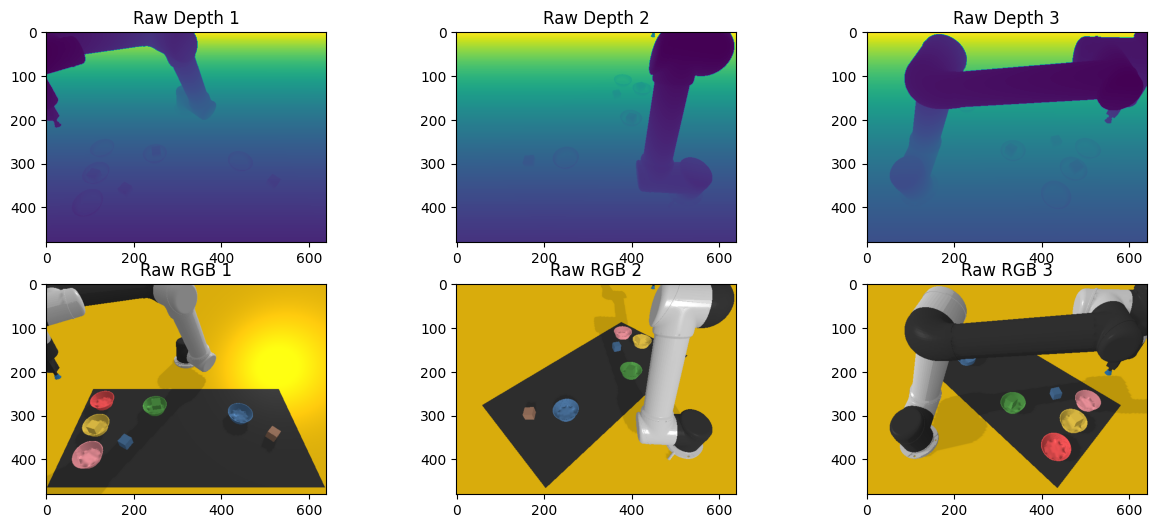

Mean: 0.0 | Task: put-block-in-bowl-seen-colors | Ckpt: last.ckpt


XIO:  fatal IO error 11 (Resource temporarily unavailable) on X server ":0"
      after 5117 requests (5117 known processed) with 0 events remaining.


In [10]:
# main(model_task="", eval_task="put-block-in-bowl-seen-colors", agent="cliport", mode="test", n_demos=10, train_demos=1000, exp_folder="exp", checkpoint_type="test_best", update_results=True, disp=True)
main(vcfg)